# SSF 训练log分享与可视化脚本
路径层级为：
output/<MODEL_TYPE>/<DATASET_MISSION>/<DATASET_NAME>/<METHOD_NAME>/<EXACT_TRAINING>


In [1]:
import csv
import os
import sys
import pandas
import numpy as np

## VTAB LOGS

VTAB任务路径：

SSF/output/vit_base_patch16_224_in21k/vtab/

具体任务路径组成：

...vtab/<单个数据集>/<方法名>/<训练日志文件夹>/summary.csv


SSF/output/vit_base_patch16_224_in21k/vtab/caltech101/ssf/20230522-115426-vit_base_patch16_224_in21k-224/summary.csv

### 加载Log文件：

In [2]:
# 
LOG_DIR="/data/PEFT/output/"
LOG_DIR="/data/work_dirs/PEFT/"
PAPER_RESULT={
    "caltech101":92.6,
    "dsprites_loc":77.3,
    "cifar_100":69.0,
    "clevr_dist":62.3,
    "dsprites_ori":54.9,
    "clevr_count":75.9,
    "dmlab":53.3,
    "diabetic_retinopathy":75.5,
    "dtd":75.1,
    "patch_camelyon":87.4,
    "eurosat":95.9,
    "pets":91.8,
    "kitti":80.6,
    "flowers102":99.4,
    "resisc45":87.4,
    "svhn":90.2,
    "smallnorb_azi":29.5,
    "smallnorb_ele":37.9,
    "sun397":52.9,
}
method_name="ssf"
log_path="vit_base_patch16_224_in21k/vtab"
# csv.reader(open(sys.argv[1], 'r'), delimiter=',')
# List all files in a directory using scandir()
basepath = os.path.join(LOG_DIR,log_path)
ssf_log_dict_vtab={}

with os.scandir(basepath) as datasets:
    for dataset in datasets:
        print(dataset.name)
        if dataset.is_dir():
            with os.scandir(dataset) as methods:
                for method in methods:
                    # print(method.name)
                    if method.is_dir() and method.name==method_name:
                        ssf_log_dict_vtab[dataset.name]=[]
                        with os.scandir(method) as runs:
                            for run in runs:
                                print("\t",run.name)
                                if run.is_dir():
                                    with os.scandir(run) as files:
                                        for file in files:
                                            if file.name.endswith(".csv"):
                                                # print(file.name)
                                                with open(file, newline='') as csvfile:
                                                    reader = csv.reader(csvfile, delimiter=',')
                                                    # Use pandas to load data.
                                                    df = pandas.read_csv(file)
                                                    ssf_log_dict_vtab[dataset.name].append(df)
                                                    
        

caltech101
	 20230523-003417-vit_base_patch16_224_in21k-224
	 20230523-003426-vit_base_patch16_224_in21k-224
patch_camelyon
	 20230523-084326-vit_base_patch16_224_in21k-224
	 20230523-084235-vit_base_patch16_224_in21k-224
cifar_100
	 20230523-004913-vit_base_patch16_224_in21k-224
	 20230523-004859-vit_base_patch16_224_in21k-224
clevr_count
	 20230523-010912-vit_base_patch16_224_in21k-224
	 20230523-010916-vit_base_patch16_224_in21k-224
dtd
	 20230523-075311-vit_base_patch16_224_in21k-224
	 20230523-075402-vit_base_patch16_224_in21k-224
eurosat
	 20230523-080218-vit_base_patch16_224_in21k-224
	 20230523-080309-vit_base_patch16_224_in21k-224
smallnorb_ele
	 20230523-114115-vit_base_patch16_224_in21k-224
	 20230523-114124-vit_base_patch16_224_in21k-224
svhn
	 20230523-124236-vit_base_patch16_224_in21k-224
	 20230523-124300-vit_base_patch16_224_in21k-224
dsprites_loc
	 20230523-040401-vit_base_patch16_224_in21k-224
	 20230523-040352-vit_base_patch16_224_in21k-224
diabetic_retinopathy
	 202

### 提取最佳表现进行比较

give the highest performance of every dataset.

csv formed like :

epoch,train_loss,eval_loss,eval_top1,eval_top5

0,6.497406005859375,6.088685486522025,0.6903353057199211,4.35568704799474


In [3]:
print("Results of VTAB:")
print("Repro\tPaper\tDrop\tave\tvar\tDataset")
mean=0
for dn,dfs in ssf_log_dict_vtab.items():
    # print(dn)
    maxes=np.array([df["eval_top1"].max() for df in dfs])
    all_max=maxes.max()
    mean+=all_max
    avg,var=maxes.mean(),maxes.var()
    # printed float only keep 3 decimal places
    print("{:.3f}\t{}\t{:.3f}\t{:.3f}\t{:.3f}\t{}".format(all_max, \
        PAPER_RESULT[dn],all_max-PAPER_RESULT[dn],avg,var,dn))
mean/=len(ssf_log_dict_vtab)
pmean=np.array(list(PAPER_RESULT.values())).mean()
print("{:.3f}\t{:.1f}\t{:.3f}\t{:.3f}\t{:.3f}\t{}".format(mean, \
    pmean,mean-pmean,mean,0,"ALL"))


Results of VTAB:
Repro	Paper	Drop	ave	var	Dataset
92.390	92.6	-0.210	92.390	0.000	caltech101
85.355	87.4	-2.045	85.355	0.000	patch_camelyon
67.830	69.0	-1.170	67.830	0.000	cifar_100
77.367	75.9	1.467	77.367	0.000	clevr_count
73.511	75.1	-1.589	73.511	0.000	dtd
96.019	95.9	0.119	96.019	0.000	eurosat
36.362	37.9	-1.538	36.362	0.000	smallnorb_ele
91.499	90.2	1.299	91.499	0.000	svhn
71.027	77.3	-6.273	71.027	0.000	dsprites_loc
76.203	75.5	0.703	76.203	0.000	diabetic_retinopathy
51.922	52.9	-0.978	51.922	0.000	sun397
60.947	62.3	-1.353	60.947	0.000	clevr_dist
29.942	29.5	0.442	29.942	0.000	smallnorb_azi
91.608	91.8	-0.192	91.608	0.000	pets
54.601	54.9	-0.299	54.601	0.000	dsprites_ori
87.984	87.4	0.584	87.984	0.000	resisc45
78.792	80.6	-1.808	78.792	0.000	kitti
99.382	99.4	-0.018	99.382	0.000	flowers102
53.123	53.3	-0.177	53.123	0.000	dmlab
72.414	73.1	-0.686	72.414	0.000	ALL


### 合并log里的loss数据：

np.savetxt("eval_losses.csv", eval_losses, delimiter=",")
np.savetxt("train_losses.csv", train_losses, delimiter=",")

In [4]:
# title,eval_losses,train_losses=[],[],[]
# for dn,dfs in ssf_log_dict_vtab.items():
#     title.append(dn)
#     eval_losses.extend([[dn,*list(df["eval_loss"])] for df in dfs])
#     train_losses.extend([[dn,*list(df["train_loss"])] for df in dfs])
# # list save to csv
# with open("eval_losses.csv", "w", newline="") as f:
#     writer = csv.writer(f)
#     writer.writerows(eval_losses)
# with open("train_losses.csv", "w", newline="") as f:
#     writer = csv.writer(f)
#     writer.writerows(train_losses)


### Train loss + eval loss 作图

每个数据集一个子图

<Figure size 640x480 with 0 Axes>

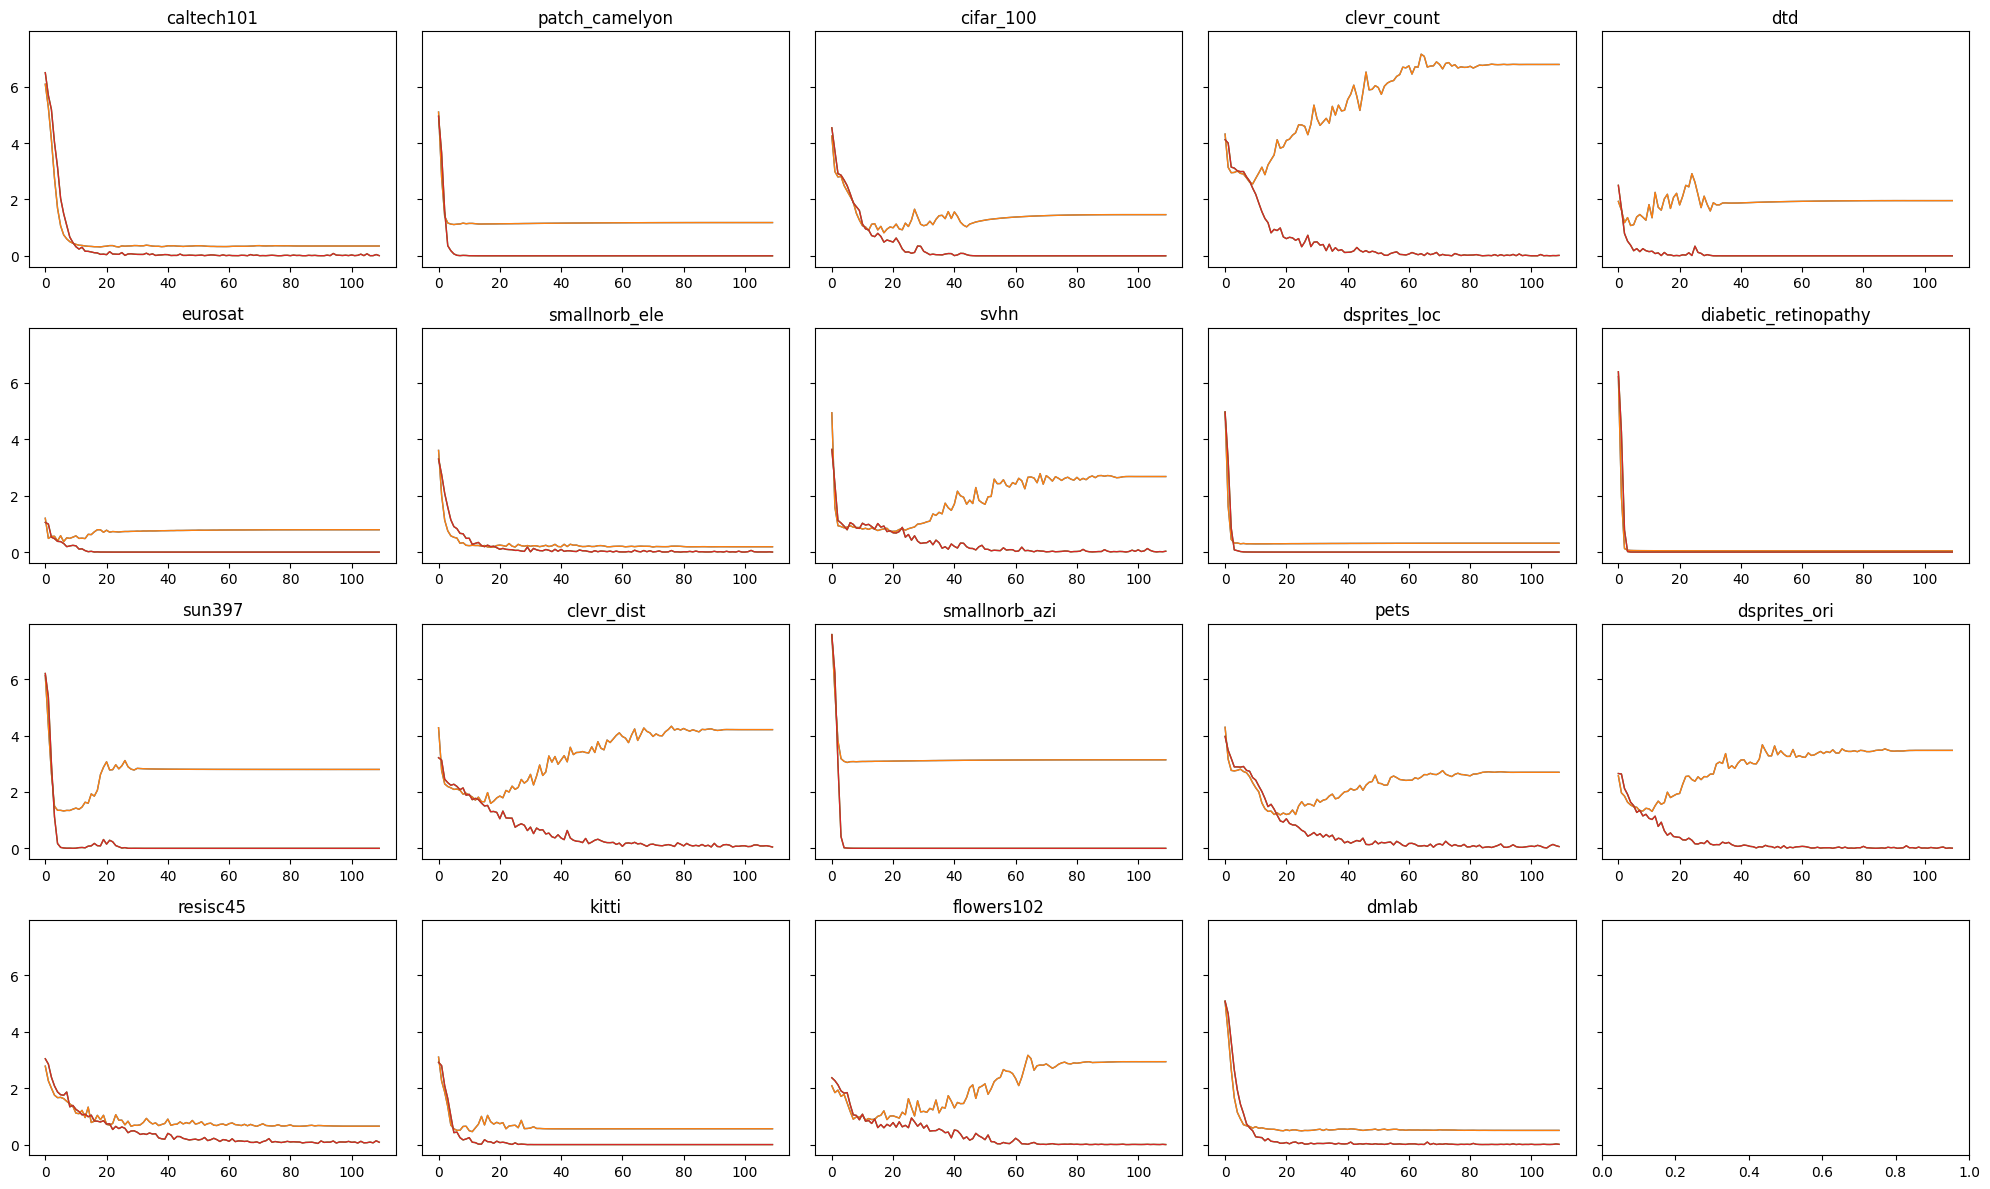

In [5]:
import warnings
warnings. filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.models as models

row=4
subp_num=len(ssf_log_dict_vtab)
col=int(np.ceil(subp_num/row))
plt.clf()
fig, axs = plt.subplots(ncols=col, nrows=row, sharey='all')#,gridspec_kw={"hspace": 0, "wspace": 0})
fig.set_size_inches(20, 12)

for i,(dn,dfs) in enumerate(ssf_log_dict_vtab.items()):
    line_num=len(dfs)*2
    data=[df["eval_loss"] for df in dfs]
    data.extend([df["train_loss"] for df in dfs])
    arr = np.array(data)
    # print(arr.shape)
    x=[i for i in range(len(arr[0,:]))]
    # plot subplot line chart
    # plt.subplot(i)
    # plt.plot(arr,linewidth=0.5)
    # for j in range(num_rows):
    for c in arr:
        axs[i%4,i//4].plot(x,c,linewidth=1)
    # # plot mean line
    # axs[i//col,i%col].set_xticks([])
    # axs[i].set_xlabel(f"{i+1}")
    label=dn
    axs[i//col,i%col].set_title(label)
# sns.set_style('white')
# sns.set(style='whitegrid')
# sns.despine(right=True,left=True)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
# plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.tight_layout()

plt.show()


## FULL CIFAR100 / IMAGENET1K LOGS

CIFAR100/ImageNet1k任务路径：

SSF/output/vit_base_patch16_224_in21k/cifar_100/

具体任务路径组成：

...cifar_100/<方法名>/<训练日志文件夹>/summary.csv


SSF/output/vit_base_patch16_224_in21k/vtab/caltech101/ssf/20230522-115426-vit_base_patch16_224_in21k-224/summary.csv


In [6]:
# 
PAPER_RESULT={
    "cifar_100":93.99,
    "imagenet_1k":83.10,
}
method_name="ssf"
cifar_log_path="./vit_base_patch16_224_in21k/"
# csv.reader(open(sys.argv[1], 'r'), delimiter=',')
# List all files in a directory using scandir()
basepath = os.path.join(LOG_DIR,cifar_log_path)
ssf_log_dict_cifar={}
dataset_names=["cifar_100",]
with os.scandir(basepath) as datasets:
    for dataset in datasets:
        print(dataset.name)
        if dataset.is_dir() and dataset.name in dataset_names:
            with os.scandir(dataset) as methods:
                for method in methods:
                    # print(method.name)
                    if method.is_dir() and method.name==method_name:
                        ssf_log_dict_cifar[dataset.name]=[]
                        with os.scandir(method) as runs:
                            for run in runs:
                                print("\t",run.name)
                                if run.is_dir():
                                    with os.scandir(run) as files:
                                        for file in files:
                                            if file.name.endswith(".csv"):
                                                # print(file.name)
                                                with open(file, newline='') as csvfile:
                                                    reader = csv.reader(csvfile, delimiter=',')
                                                    # Use pandas to load data.
                                                    df = pandas.read_csv(file)
                                                    ssf_log_dict_cifar[dataset.name].append(df)
                                                    
        

vtab
cifar_100
	 20230523-132650-vit_base_patch16_224_in21k-224


In [7]:
# give the highest performance of every dataset.
# csv formed like :
# epoch,train_loss,eval_loss,eval_top1,eval_top5
# 0,6.497406005859375,6.088685486522025,0.6903353057199211,4.35568704799474
print("Results of CIFAR10 \\ ImageNet:")
print("Repro\tPaper\tave\tvar\tDataset")
for dn,dfs in ssf_log_dict_cifar.items():
    # print(dn)
    maxes=np.array([df["eval_top1"].max() for df in dfs])
    all_max=maxes.max()
    avg,var=maxes.mean(),maxes.var()
    # printed float only keep 3 decimal places
    print("{:.3f}\t{}\t{:.3f}\t{:.3f}\t{:.3f}\t{}".format(all_max, \
        PAPER_RESULT[dn],all_max-PAPER_RESULT[dn],avg,var,dn))

Results of CIFAR10 \ ImageNet:
Repro	Paper	ave	var	Dataset
93.590	93.99	-0.400	93.590	0.000	cifar_100
